# SMAI Assignment - 2

## Question 1: Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [1]:
import pickle
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rhythmaggarwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rhythmaggarwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rhythmaggarwal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rhythmaggarwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
with open('train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

In [3]:
data = pd.read_csv('product_reviews.csv')
data.head()

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,Went in for a lunch. Steak sandwich was delici...,5.0,1
2,This place has gone down hill. Clearly they h...,1.0,0
3,"Walked in around 4 on a Friday afternoon, we s...",1.0,0
4,Michael from Red Carpet VIP is amazing ! I rea...,4.0,1


In [20]:
remove_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
remove_words.update(['.','?','!',',',"'",'"'])
def text_processing(text):
    '''
    punctuations removed, lemmatization and stop words removed
    '''
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in remove_words]
    money_sub_text = re.sub(r'(\$ \w+)|([0-9]+ cent)', '<MONEY>', ' '.join(lemmatized_tokens))
    num_sub_text = re.sub(r'\b[0-9]+\b', '<NUM>', money_sub_text)
    return num_sub_text

data['text'] = data['text'].apply(text_processing)
        

In [21]:
data.head()

,text,stars,sentiment
0,Total bill horrible service <MONEY> crook actu...,1.0,0
1,Went lunch Steak sandwich delicious Caesar sal...,5.0,1
2,place gone hill Clearly cut back staff food qu...,1.0,0
3,Walked around <NUM> Friday afternoon sat table...,1.0,0
4,Michael Red Carpet VIP amazing reached needed ...,4.0,1


In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

classifier = MultinomialNB()

In [23]:
def vectorize_features(type = 1):
    if type == 1:
        vectorizer = CountVectorizer()
    else:
        vectorizer = TfidfVectorizer()
        
    document_term = vectorizer.fit_transform(data['text']).toarray()
#     features = np.concatenate((document_term, np.expand_dims(data['stars'].values, 1)), axis = 1)
    target = data['stars'].values
    return document_term, target

In [24]:
features, target = vectorize_features(1)
x_train = features[train_test_index_dict['train_index']]
x_test = features[train_test_index_dict['test_index']]
y_train = target[train_test_index_dict['train_index']]
y_test = target[train_test_index_dict['test_index']]

# Train the classifier
classifier.fit(x_train, y_train)

# Predict on the test set
y_pred = classifier.predict(x_test)

# Print classification report
print(accuracy_score(y_test, y_pred))

0.7008750994431185


In [25]:
features, target = vectorize_features(2)
x_train = features[train_test_index_dict['train_index']]
x_test = features[train_test_index_dict['test_index']]
y_train = target[train_test_index_dict['train_index']]
y_test = target[train_test_index_dict['test_index']]

# Train the classifier
classifier.fit(x_train, y_train)

# Predict on the test set
y_pred = classifier.predict(x_test)

# Print classification report
print(accuracy_score(y_test, y_pred))

0.5904080009091942


### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [4]:
import gzip
import numpy as np

f = gzip.GzipFile('roberta_embeds.npy.gz', "r")
embeds = np.load(f)
target = data['stars'].values.astype('int')
print(embeds.shape)

(26661, 1024)


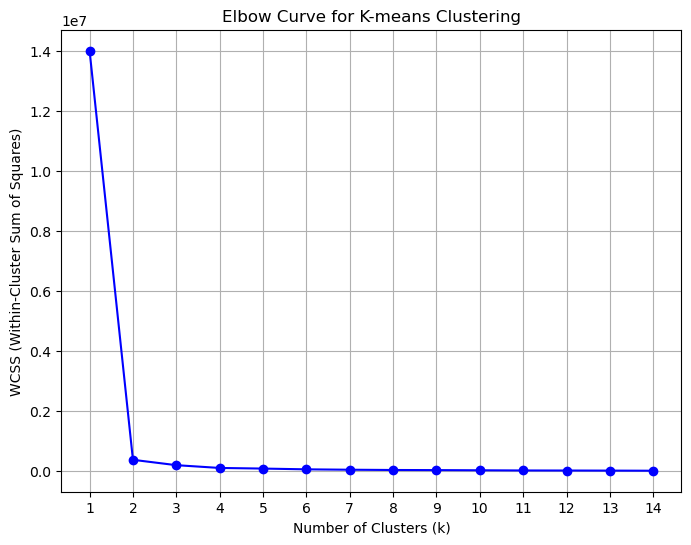

In [86]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate Within-Cluster Sum of Squares (WCSS) for different values of k
wcss = []
for k in range(1, 15):
    kmeans = KMeans(init = 'k-means++', n_clusters=k, n_init = 1)
    kmeans.fit(embeds)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Curve for K-means Clustering')
plt.xticks(np.arange(1, 15, 1))
plt.grid(True)
plt.show()

In [87]:
elbow_k = 3
kmeans = KMeans(init = 'k-means++', n_clusters=elbow_k, n_init = 1)
kmeans.fit(embeds)
np.unique(kmeans.labels_)

array([0, 1, 2], dtype=int32)

In [88]:
clusters = {}
for k in range(elbow_k):
    clusters[k] = np.where(kmeans.labels_ == k)[0]

In [89]:
def purity():
    N = len(target)
    correct_classification = 0
    for cluster in clusters:
        star_class = target[clusters[cluster]]
        counts = np.bincount(star_class)
        correct_classification += np.max(counts)
    
    return correct_classification / N

def nmi():
    N = len(target)
    tp_fp_tn_fn = N*(N-1) / 2
    
    class_counts = np.bincount(target)
    cluster_counts = np.bincount(kmeans.labels_)
    nmi_metric_information = 0
    for cluster in clusters:
        star_class = target[clusters[cluster]]
        counts = np.bincount(star_class)
        nmi_metric_cluster = 0
        for idx, stars in enumerate(counts):
            nmi_metric_cluster += 0.0 if stars == 0 else stars*(np.log2((N*stars)/(class_counts[idx]*np.sum(counts))))
        nmi_metric_information += nmi_metric_cluster
    
    nmi_metric_information /= N
    
    class_counts_prob = class_counts[class_counts > 0] / N
    cluster_counts_prob = cluster_counts[cluster_counts > 0] / N
    
    entropy_class = -np.sum(class_counts_prob * np.log2(class_counts_prob))
    entropy_cluster = -np.sum(cluster_counts_prob * np.log2(cluster_counts_prob))
    
    return 2*nmi_metric_information / (entropy_class + entropy_cluster)
        
        
def randi():
    N = len(target)
    tp_fp_tn_fn = N*(N-1) / 2
    class_counts = np.bincount(target)
    cluster_counts = np.bincount(kmeans.labels_)
    tp = 0
    tn = 0
    cluster_class_counts = []
    for cluster in clusters:
        star_class = target[clusters[cluster]]
        counts = np.bincount(star_class)
        cluster_class_counts.append(counts)
    
    cluster_class_counts = np.array(cluster_class_counts)
    
    for k in range(cluster_class_counts.shape[0]):
        for j in range(cluster_class_counts.shape[1]):
            tp += cluster_class_counts[k][j]*(cluster_class_counts[k][j] - 1) / 2
            tn += cluster_class_counts[k][j]*(N - class_counts[j]-cluster_counts[k]+cluster_class_counts[k][j])
    tn /= 2
    
    return (tp+tn) / tp_fp_tn_fn
        
        
    
    

In [90]:
print(purity(), nmi(), randi())

0.70683770301189 0.5299522788101332 0.7166146240059509
